Loading the network weights

In [1]:
import os
from PIL import Image as PIL_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.feature_extraction import image as sklearn_image
#matplotlib inline
import theano
import lasagne
import time
import random
import math
import cPickle
random.seed(0)

C:\Users\s119104\AppData\Local\Continuum\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
def buildLeNet(X1):
    #rectify, softmax, sigmoid
    inputlayer = lasagne.layers.InputLayer(shape=(None, 1, 32, 32),input_var=X1)    
    print inputlayer.output_shape
    
    layer1 = lasagne.layers.Conv2DLayer(inputlayer, num_filters=6, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    print layer1.output_shape 
    
    layer2 = lasagne.layers.MaxPool2DLayer(layer1, pool_size=(2, 2))
    print layer2.output_shape 
    
    layer3 = lasagne.layers.Conv2DLayer(layer2, num_filters=16, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    print layer3.output_shape 
    
    layer4 = lasagne.layers.MaxPool2DLayer(layer3, pool_size=(2, 2))
    print layer4.output_shape 
    
    layer4 = lasagne.layers.flatten(layer4)
    print layer4.output_shape 
    
    layer5 = lasagne.layers.DenseLayer(layer4,num_units=120,nonlinearity=lasagne.nonlinearities.rectify)    
    print layer5.output_shape 
    
    layer6 = lasagne.layers.DenseLayer(layer5,num_units=84,nonlinearity=lasagne.nonlinearities.rectify)
    print layer6.output_shape 
    
    outputlayer = lasagne.layers.DenseLayer(layer6,num_units=2,nonlinearity=lasagne.nonlinearities.softmax)     
    print outputlayer.output_shape 
    
    return layer1, layer2, layer3, layer4, layer5, layer6, outputlayer

In [3]:
X = theano.tensor.tensor4()
Y = theano.tensor.matrix()
layer1, layer2, layer3, layer4, layer5, layer6, outputlayer = buildLeNet(X)

(None, 1, 32, 32)
(None, 6, 28, 28)
(None, 6, 14, 14)
(None, 16, 10, 10)
(None, 16, 5, 5)
(None, 400)
(None, 120)
(None, 84)
(None, 2)


In [17]:
def load_weights(filename, network):
    with open(filename, 'rb') as f:
        lasagne.layers.set_all_param_values(network, cPickle.load(f))
        losslist = cPickle.load(f)
        validlosslist = cPickle.load(f)
        
    return(losslist, validlosslist)

network = outputlayer
project_path = os.getcwd()
filename = project_path + '/Project1_weights.pkl'
losslist, validlosslist = load_weights(filename, network)           

Load the test images and make images of those

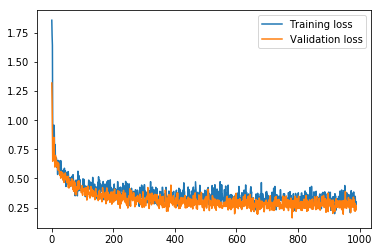

In [8]:
plt.figure()
plt.plot(losslist[10:])
plt.plot(validlosslist[10:])
plt.legend(['Training loss','Validation loss'])
plt.show()

In [11]:
# The function that loads the data
def loadData(data_set = 'test', image = '1st_manual'):
    
    # Check for the correct input
    if data_set != 'test' and data_set != 'training':
        raise Exception('Not the right data_set file')
    if image != '1st_manual' and image != '2nd_manual' and image != 'images' and image != 'mask':
        raise Exception('Not the right image file')
    if data_set == 'training' and image == '2nd_manual':
        raise Exception('File not available')
    
    # Project and image path
    project_path = os.getcwd()
    images_path = project_path +  '/8DM20_image_dataset/' + data_set + '/' + image + '/'
    
    images = []
    
    #Open image for image (20 in total for each of them)
    for i in range(1, 21):
        
        # Find correct image number
        image_nr = str(i)
        if data_set == 'training':
            image_nr = str(20 + i)
        elif len(image_nr) == 1:
            image_nr = '0' + image_nr
            
        # Specify path for this image
        if image == '1st_manual':
            image_path = images_path + image_nr + '_manual1.gif'
        elif image == '2nd_manual':
            image_path = images_path + image_nr + '_manual2.gif'
        elif image == 'images':
            image_path = images_path + image_nr + '_' + data_set + '.tif'
        elif image == 'mask':
            image_path = images_path + image_nr + '_' + data_set + '_mask.gif'
        
        # Open and append the image to the image list
        images.append(PIL_image.open(image_path))
        
    return images

#The function that converts the channels in the images from RGB to gray
#and makes matrices from the images
def convertImageToMatrix(images):
    
    image_matrices = []
    
    for image in images:
        image_matrix = np.asarray(image.convert('RGB'))
        green_image_matrix = image_matrix[:,:,1]
        image_matrices.append(green_image_matrix)
        
    return image_matrices

#The function that prepares the image matrices to the data used for machine learning
def prepareMachineLearningData(image_matrix, output_matrix, mask_matrix, kernel_size, mask_removal = 'pixel'):
    #Check if correct input
    if not (isinstance(image_matrix, np.ndarray) and 
            isinstance(output_matrix, np.ndarray) and 
            isinstance(mask_matrix, np.ndarray)):
        raise Exception("Not all input matrices are numpy matrices")
    
    if mask_removal != 'pixel' and mask_removal != 'patch':
        raise Exception("Unknown mask data removal type")
    
    if not (image_matrix.shape == output_matrix.shape == mask_matrix.shape):
        raise Exception("The images are not the same size")
    
    if np.unique(mask_matrix).shape[0] != 2:
        raise Exception("The mask matrix does not consist of only 2 values")
    
    # Matrix reduction
    mat_red = kernel_size / 2
    
    # Makes some additional mask values zero on the edge of the mask
    new_mask_matrix = mask_matrix.copy()
    
    image_patches = []
    output_array = []
    
    # Remove patch pixels with masks
    if mask_removal == 'patch':
        for i in range(mat_red - 1, mask_matrix.shape[0] - mat_red):
            for j in range(mat_red - 1, mask_matrix.shape[1] - mat_red):
                if 0 in mask_matrix[i - mat_red + 1: i + mat_red + 1, j - mat_red + 1: j + mat_red + 1]:
                    new_mask_matrix[i,j] = 0;
    
    # Append the patches append the output
    for i in range(mat_red - 1, mask_matrix.shape[0] - mat_red):
        for j in range(mat_red - 1, mask_matrix.shape[1] - mat_red):
            if new_mask_matrix[i][j] > 0:
                image_patches.append(image_matrix[i - mat_red + 1: i + mat_red + 1, j - mat_red + 1: j + mat_red + 1])
                output_array.append(output_matrix[i][j])
    
    # Make the image have the right dimensions
    corr_image_patches = np.expand_dims(image_patches, axis=1)
    
    return corr_image_patches, output_array

# Prepare multiple images at once
def prepareMultipleImages(image_matrices, output_matrices, mask_matrices, kernel_size = 25, mask_removal = 'pixel'):
    #Check if correct input
    if not (isinstance(image_matrices, list) and 
            isinstance(output_matrices, list) and 
            isinstance(mask_matrices, list)):
        raise Exception("Not all input matrices are numpy matrices")
    
    if not (len(image_matrices) == len(output_matrices) == len(mask_matrices)):
        raise Exception("The images are not the same size")
    
    image_patches = [] 
    output_arrays = []
    
    # Finds the output data per image
    for i in range(len(image_matrices)):
        new_image_patches, new_output_array = prepareMachineLearningData(image_matrices[i], output_matrices[i], mask_matrices[i], 
                                                                         kernel_size = kernel_size, mask_removal = mask_removal)
        image_patches.append(new_image_patches)
        output_arrays.append(new_output_array)
        
        #Print progress for showing time consumption
        print"Progress: {} %".format(100*(i+1)/len(image_matrices)),
              
    return image_patches, output_arrays

def createVesselImage(output_array, mask_matrix, kernel_size, mask_removal = "pixel"):
    #Check if input is correct
    if not isinstance(output_array, list) or not isinstance(mask_matrix, np.ndarray) or not isinstance(kernel_size, int):
        raise Exception("Not the right input variables")
    
    if mask_removal != "pixel" and mask_removal != 'patch':
        raise Exception("Unknown mask removal type")
    
    #Create an output_matrix for the output array
    #output_matrix = np.array(mask_matrix)
    output_matrix = np.zeros(mask_matrix.shape)
    output_loc = 0
    
    # Take into account that mask pixels too close to the border are lost due to inability to make patches
    edge_corr = int(math.ceil(kernel_size / 2) - 1)
    
    new_mask_matrix = mask_matrix.copy()
    
    # Makes some additional mask values zero on the edge of the mask
    if mask_removal == 'patch':
        for i in range(edge_corr, mask_matrix.shape[0] - edge_corr - 2):
            for j in range(edge_corr, mask_matrix.shape[1] - edge_corr - 2):
                if 0 in mask_matrix[i - edge_corr  : i + edge_corr + 2, j - edge_corr: j + edge_corr + 2]:
                    new_mask_matrix[i,j] = 0;
       
    # Check every pixel within the mask for a vessel pixel
    for i in range(mask_matrix.shape[0] - kernel_size + 1):
        for j in range(mask_matrix.shape[1] - kernel_size + 1):
            if new_mask_matrix[i + edge_corr, j + edge_corr] == 255:
                output_matrix[i + edge_corr, j + edge_corr] = output_array[output_loc]
                output_loc += 1
                
    return output_matrix 

In [13]:
nr_images_test = 1

# All test image lists
test_manual1_images = loadData('test', '1st_manual')
test_manual2_images = loadData('test', '2nd_manual')
test_raw_images = loadData('test', 'images')
test_mask_images = loadData('test', 'mask')

# Making matrices of the test images to work with
test_manual1_matrices = convertImageToMatrix(test_manual1_images)
test_manual2_matrices = convertImageToMatrix(test_manual2_images)
test_raw_matrices = convertImageToMatrix(test_raw_images)
test_mask_matrices = convertImageToMatrix(test_mask_images)

test_image_patches, test_output_array = prepareMultipleImages(test_raw_matrices[0:nr_images_test], test_manual1_matrices[0:nr_images_test], 
                                                     test_mask_matrices[0:nr_images_test], 32, mask_removal = 'patch')

 Progress: 100 %


In [15]:
def buildLeNet(X1):
    inputlayer = lasagne.layers.InputLayer(shape=(None, 1, 32, 32),input_var=X1)    
    print inputlayer.output_shape
    
    layer1 = lasagne.layers.Conv2DLayer(inputlayer, num_filters=6, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    print layer1.output_shape 
    
    layer2 = lasagne.layers.MaxPool2DLayer(layer1, pool_size=(2, 2))
    print layer2.output_shape 
    
    layer3 = lasagne.layers.Conv2DLayer(layer2, num_filters=16, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    print layer3.output_shape 
    
    layer4 = lasagne.layers.MaxPool2DLayer(layer3, pool_size=(2, 2))
    print layer4.output_shape 
    
    layer4 = lasagne.layers.flatten(layer4)
    print layer4.output_shape 
    
    layer5 = lasagne.layers.DenseLayer(layer4,num_units=120,nonlinearity=lasagne.nonlinearities.rectify)    
    print layer5.output_shape 
    
    layer6 = lasagne.layers.DenseLayer(layer5,num_units=84,nonlinearity=lasagne.nonlinearities.rectify)
    print layer6.output_shape 
    
    outputlayer = lasagne.layers.DenseLayer(layer6,num_units=2,nonlinearity=lasagne.nonlinearities.softmax)     
    print outputlayer.output_shape 
    
    return layer1, layer2, layer3, layer4, layer5, layer6, outputlayer

In [16]:
X = theano.tensor.tensor4()
Y = theano.tensor.matrix()
layer1, layer2, layer3, layer4, layer5, layer6, outputlayer = buildLeNet(X)

outputtrain = lasagne.layers.get_output(outputlayer) #function that gets the output from the network defined before.
trainloss = lasagne.objectives.categorical_crossentropy(outputtrain, Y).mean() #function that computes the mean crossentropy between the output and the real labels.
params = lasagne.layers.get_all_params(outputlayer, trainable=True) #function that gets all the parameters (weights) in the network.
updates = lasagne.updates.adam(trainloss, params, learning_rate=0.001) #function that performs an update of the weights based on the loss.
train = theano.function(inputs=[X, Y], outputs=trainloss, updates=updates, allow_input_downcast=True) #function that does all the above based on training samples X and real labels Y.

validate = theano.function(inputs=[X, Y], outputs=trainloss, allow_input_downcast=True) #function that computes the loss without performing an update

outputtest = lasagne.layers.get_output(outputlayer, deterministic=True) #function that gets the output from the network defined before.
test = theano.function(inputs=[X], outputs=outputtest, allow_input_downcast=True) #function that gets the output based on input X

(None, 1, 32, 32)
(None, 6, 28, 28)
(None, 6, 14, 14)
(None, 16, 10, 10)
(None, 16, 5, 5)
(None, 400)
(None, 120)
(None, 84)
(None, 2)

C:\Users\s119104\AppData\Local\Continuum\Anaconda2\lib\site-packages\lasagne\layers\conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [26]:
t0 = time.time()

test_results = []
for i in range(nr_images_test):
    test_image_predictions = []
    for j in range(0,len(test_image_patches[i]), 500):
        if j + 500 >= len(test_image_patches[i]):
            testing = test(test_image_patches[i][j:j+len(test_image_patches[i])])
        else:
            testing = test(test_image_patches[i][j:j+500])
        
        test_set_predictions = np.argmax(testing, axis = 1)
        test_image_predictions.extend(test_set_predictions)
        if j%10000 == 0:
            print("Currently at %d percent of image" % (100*j/len(test_image_patches[i])))
   
    test_results.append(test_image_predictions)
    print("Currently at image %d" % i)
    print("Fraction of vessel pixels %d of" % (sum(test_image_predictions)))


t1 = time.time()
print 'Testing time: {} seconds'.format(t1-t0)


Currently at 0 percent of image
Currently at 5 percent of image
Currently at 10 percent of image
Currently at 15 percent of image
Currently at 20 percent of image
Currently at 26 percent of image
Currently at 31 percent of image
Currently at 36 percent of image
Currently at 41 percent of image
Currently at 46 percent of image
Currently at 52 percent of image
Currently at 57 percent of image
Currently at 62 percent of image
Currently at 67 percent of image
Currently at 72 percent of image
Currently at 78 percent of image
Currently at 83 percent of image
Currently at 88 percent of image
Currently at 93 percent of image
Currently at 98 percent of image
Currently at image 0
Fraction of vessel pixels 42786 of
Testing time: 98.7030000687 seconds


In [29]:
createVesselImage(test_results[0],test_mask_matrices[0], 32, mask_removal = "patch")

IndexError: list index out of range